*This notebook provides comprehensive guide of sentiment analysis and topic modeling of coronavirus tweets between March 1 and September 30 2020*
### Group 6
### Azat Dovgeldiyev, Hans Bermann

### Contents:
1. **Data Preprocessing Phase**
    * Cleaning with removing columns, adding new ones to get length of tweet
    * Case Conversion: All words are converted either into lower case
    * Stop words removal
    * Punctuation Removal
    * Spelling Correction
   
2. **Sentiment Analysis**
    * calculate polarity level of tweets
    * create word cloud
    * calculate term frequency and inverse document frequency

3. **Classification**
    * create target variable from sentiment scores
    * calculate term frequency
    * Perform Logistic regression , LinearSVC, XGBoost to predict sentiment scores (3 target labels)

4. **Clustering**
    * Implement KMeans clustering
    * reduce components
    * perform Gaussian Mixture
    * get top features for each cluster
    
5. **Topic Modeling with LDA**
    * Vectorize documents
    * compute n-grams
    * visualize number of topics



In [ ]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
np.set_printoptions(suppress=True)

In [ ]:
#control warnings
import sys
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore")

In [ ]:
#text preprocessing packages
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/Capstone-project/"

 df_0.csv   sent-2020-09-30.csv
 df_1.csv  'Sentiment Analysis and Topic Modeling.ipynb'
 df_2.csv   twitter-scraping.ipynb
 images     vis.html


In [ ]:
#read data
df=pd.read_csv("/content/gdrive/My Drive/Capstone-project/sent-2020-09-30.csv")
df.head()

,id,date,tweet
0,1311091266243850240,2020-09-29 23:51:31+00:00,#MannKiBaat\nDuring the time of the coronaviru...
1,1311089691609849856,2020-09-29 23:45:16+00:00,Airlines brace for lower Thanksgiving travel i...
2,1311087858367823873,2020-09-29 23:37:58+00:00,WE hope the Coronavirus Pandemic is vanquished...
3,1311085483800363008,2020-09-29 23:28:32+00:00,"A reminder, this first debate will cover: Trum..."
4,1311084140180189189,2020-09-29 23:23:12+00:00,"Apart from the ongoing coronavirus pandemic, w..."


In [ ]:
#split dates and add extra column for month
df['Date'] = pd.to_datetime(df['date']).dt.date
df['month'] = pd.to_datetime(df['date']).dt.strftime('%b')
df['time'] = pd.to_datetime(df['date']).dt.time
df.sample(5)

,id,date,tweet,Date,month,time
104587,1242320265197105154,2020-03-24 05:20:07+00:00,Ethiopia started distributing China’s donation...,2020-03-24,Mar,05:20:07
47618,1259517603036434434,2020-05-10 16:16:11+00:00,#trade ON Semiconductor Quarterly Earnings Mis...,2020-05-10,May,16:16:11
38270,1265349690746437634,2020-05-26 18:30:49+00:00,I think now is the time to #TakeTrumpOffTwitt...,2020-05-26,May,18:30:49
101055,1242877974124220416,2020-03-25 18:16:15+00:00,"#CoronaVillains: If you can't contribute, don'...",2020-03-25,Mar,18:16:15
12996,1289805757228048386,2020-08-02 06:10:30+00:00,Dr. @himantabiswa has emerged as a ‘hero’ in A...,2020-08-02,Aug,06:10:30


In [ ]:
#we will not use original date and id column

df.drop(columns=['id', 'date'],inplace=True)
df.head()

,tweet,Date,month,time
0,#MannKiBaat\nDuring the time of the coronaviru...,2020-09-29,Sep,23:51:31
1,Airlines brace for lower Thanksgiving travel i...,2020-09-29,Sep,23:45:16
2,WE hope the Coronavirus Pandemic is vanquished...,2020-09-29,Sep,23:37:58
3,"A reminder, this first debate will cover: Trum...",2020-09-29,Sep,23:28:32
4,"Apart from the ongoing coronavirus pandemic, w...",2020-09-29,Sep,23:23:12


In [ ]:
#sorting data by date for future

df.sort_values(by='Date',inplace=True)
df.head()

,tweet,Date,month,time
136393,"#China should not restart work, 90% of Chinese...",2020-03-01,Mar,00:06:22
136317,As folks start prepping for a coronavirus pand...,2020-03-01,Mar,18:57:29
136318,"Hey Donald, how is your “America First” messag...",2020-03-01,Mar,18:57:27
136319,As #COVID19 #coronavirus pandemic gains moment...,2020-03-01,Mar,18:55:29
136320,Imma go ahead and say it. Y'all should be wash...,2020-03-01,Mar,18:52:17


In [ ]:
#get the shape of data, number of tweets, and dates
print('shape:', df.shape)
print('number of tweets:', df['tweet'].nunique())
print("range:", df['Date'].min(),",", df['Date'].max())
print('{}% of data is unique'.format(round(df['tweet'].nunique()/df.shape[0],2)*100))

shape: (136394, 4)
number of tweets: 127310
range: 2020-03-01 , 2020-09-29
93.0% of data is unique


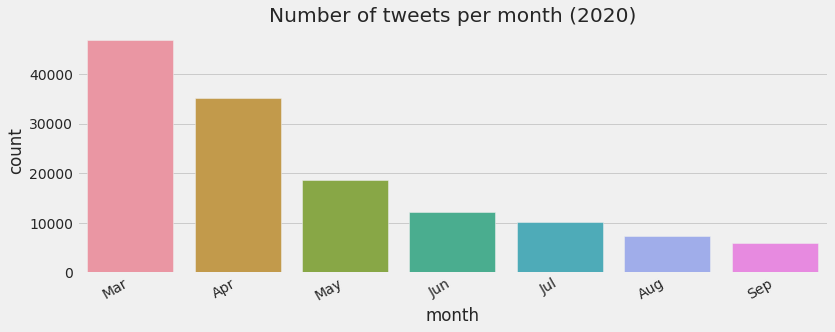

In [ ]:
#let's check number of tweets by date
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
chart = sns.countplot(df['month'])
chart.set_xticklabels(chart.get_xticklabels())
chart.set_title('Number of tweets per month (2020)')
fig.autofmt_xdate()

More tweets containing pandemic words occur in March - April as outbreak happened at that time.

Before we can really do anything useful with text data, it must be preprocessed to be a machine readable numeric input.
### Cleaning Steps
1. Remove URL’s
2. Remove stop words and punctuation
3. Remove remaining non alphabetical characters
4. Lemmatize text

In [ ]:
#preprocess texts
import re

def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    Text = Text.str.replace("b'", '')
    Text = Text.str.replace('b"', '')
    Text = Text.str.replace('\\', '')
    Text = Text.str.replace('xe2', '')
    Text = Text.str.replace('x80', '')
    Text = Text.str.replace('x99', '')
    Text = Text.str.replace('xa6', '')
    Text = Text.str.replace('nn', '')
    Text = Text.str.replace('gmt', '')
    Text = Text.str.replace('000', '')
    return Text

# remove urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row = url_pattern.sub(r'', row)
    return row

# remove @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags, com frin text
def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row = url_pattern.sub(r'', row)
    return row

In [ ]:
# apply all the preprocess functions
df['text_nlp'] = preprocess(df['tweet'])
df['text_nlp'] = df['text_nlp'].apply(remove_urls)
df['text_nlp'] = df['text_nlp'].apply(removes)

In [ ]:
#get the length of text and word count
df['text_len'] = df.text_nlp.astype(str).apply(len)
df['word_count'] = df.text_nlp.apply(lambda x: len(str(x).split()))

In [ ]:
df.sample(5)

,tweet,Date,month,time,text_nlp,text_len,word_count
57526,"Grandson: “Grandpa ^L, were you a hero during ...",2020-04-27,Apr,17:54:49,"Grandson: “Grandpa ^L, were you a hero during ...",110,18
95526,1- There is no better way for the inhabitants...,2020-03-28,Mar,12:06:23,1- There is no better way for the inhabitants...,250,45
101170,Supreme Court has directed the suspension of t...,2020-03-25,Mar,17:18:46,Supreme Court has directed the suspension of t...,259,41
25819,NEW YORK (AP) - New York City Marathon cancele...,2020-06-24,Jun,15:10:44,NEW YORK (AP) - New York City Marathon cancele...,133,24
29256,The Cases of Coronavirus Pandemic is increasin...,2020-06-18,Jun,08:32:17,The Cases of Coronavirus Pandemic is increasin...,280,45


In [ ]:
#original tweet
df['tweet'][120]

'Manhattan office employees are returning 2work at a much slower pace than those in most other major U.S. Cities, raising the risk that NYC faces a more protracted &amp; painful recovery from the coronavirus pandemic than much of the rest of the country &amp; They Have a Communist Mayor!'

In [ ]:
#preprocessed tweet
df['text_nlp'][120]

'Manhattan office employees are returning 2work at a much slower pace than those in most other major U.S. Cities, raising the risk that NYC faces a more protracted ; painful recovery from the coronavirus pandemic than much of the rest of the country ; They Have a Communist Mayor!'

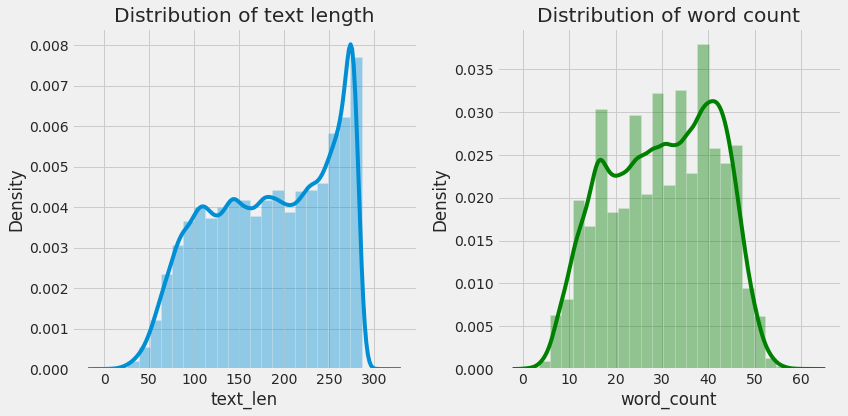

In [ ]:
#let's compare distributions

fig, axes = plt.subplots(ncols=2, figsize=(12,6))

sns.distplot(df['text_len'], bins=25,ax=axes[0])
axes[0].set_title("Distribution of text length")

sns.distplot(df['word_count'],bins=25, ax = axes[1],color='g')
axes[1].set_title("Distribution of word count")

plt.tight_layout()

In [ ]:
#let's look into top word frequencies
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['text_nlp'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
 
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
#We will remove pandemic and coronavirus since our scraping is based on two values
pndmc = frequency[(frequency['word'] == 'pandemic')].index
crnvrs = frequency[(frequency['word'] == 'coronavirus')].index
don = frequency[(frequency['word'] == 'don')].index
says = frequency[(frequency['word'] == 'says')].index
said = frequency[(frequency['word'] == 'said')].index
frequency.drop(pndmc, inplace=True)
frequency.drop(crnvrs, inplace=True)
frequency.drop(said, inplace=True)
frequency.drop(says, inplace=True)
frequency.drop(don, inplace=True)

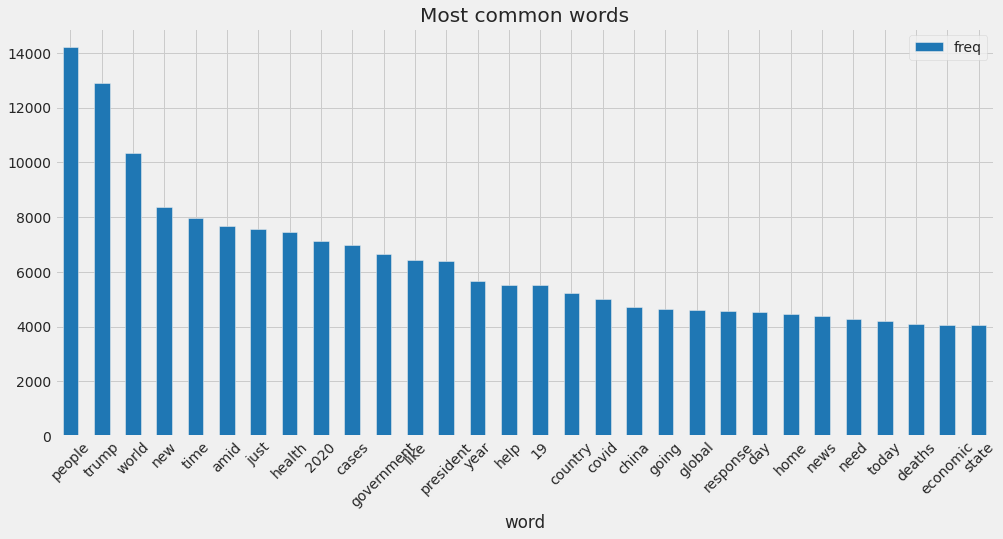

In [ ]:
frequency.head(30).plot(kind='bar',x='word', y='freq', color="#1f77b4",figsize=(15,7))
plt.title('Most common words')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Handling Abbreviation
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# decontracte words
df.text_nlp = df.text_nlp.apply(lambda x: decontracted(x).lower())

In [ ]:
df.text_nlp[200]

'pelosi and steven mnuchin, who have cut several major deals during the coronavirus pandemic, are trying one final time to ease a bitter standoff on capitol hill over a pre-election day package to provide relief to millions of americans reeling from the damaging economic crisis.'

In [ ]:
#remove stop words

stop_words = stopwords.words('english')
not_stop = {}
common_words = ['com','twitter','please',
               'the','would','could','can','may','must',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca']

stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stop])
df.text_nlp = df.text_nlp.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))

### Sentiment Analysis (calculating polarity levels of tweets)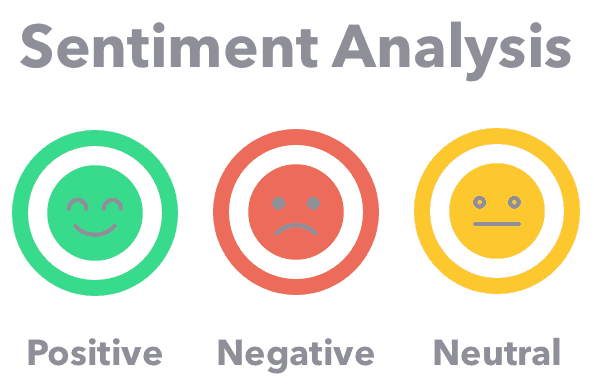

In [ ]:
#word count
from collections import Counter

#word clouds
import heapq
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from PIL import Image
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
from tqdm import tqdm

#sentiment analysis
from textblob import TextBlob

In [ ]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
# get the polarity of each text
df['polarity'] = df.text_nlp.map(lambda text: TextBlob(text).sentiment.polarity)

# classify sentiment into positive and negative ones
df['sentiment'] = ''
df['sentiment'][df['polarity'] > 0] = 'positive'
df['sentiment'][df['polarity'] == 0] = 'neutral'
df['sentiment'][df['polarity'] < 0] = 'negative'

Text(0, 0.5, 'log scale')

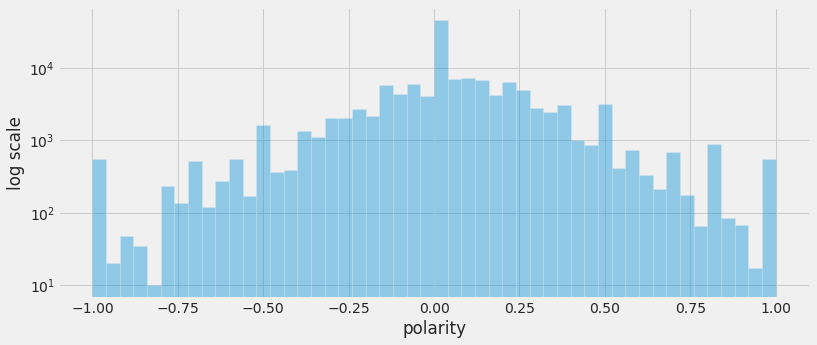

In [ ]:
fig = plt.figure(figsize=(12,5))
sns.distplot(df['polarity'],kde = False)
plt.yscale('log')
plt.ylabel('log scale')

The distribution of tweets are normal, mostly containing neutral feelings

In [ ]:
#tweet content with negative polarity
df[df['polarity']<-0.8]['tweet'].iloc[20]

'just in case u didn’t know the coronavirus pandemic is literally awful for ocd!!'

In [ ]:
df[df['polarity']>0.8]['tweet'].iloc[150]

"With the coronavirus pandemic and everyone now at home, what's everyone doing. I'm just watching the best YouTuber in the world @chrismd10 Sunday league matches🐐"

In [ ]:
# Sentiment 
df.groupby('sentiment').tweet.count()

sentiment
negative    36515
neutral     40499
positive    59380
Name: tweet, dtype: int64

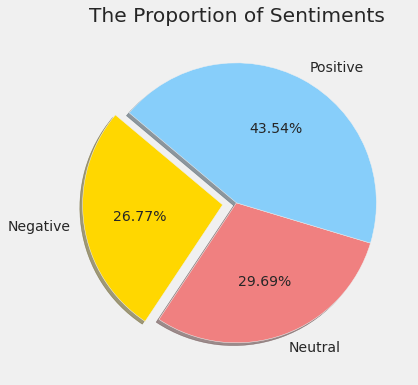

In [ ]:
# draw a pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets
fig = plt.figure(figsize=(6,6))
labels = 'Negative', 'Neutral', 'Positive'
sizes = df.groupby('sentiment').tweet.count().values
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('The Proportion of Sentiments')
plt.show()

Text(0.5, 1.0, 'Average sentiment of Tweets across Dates')

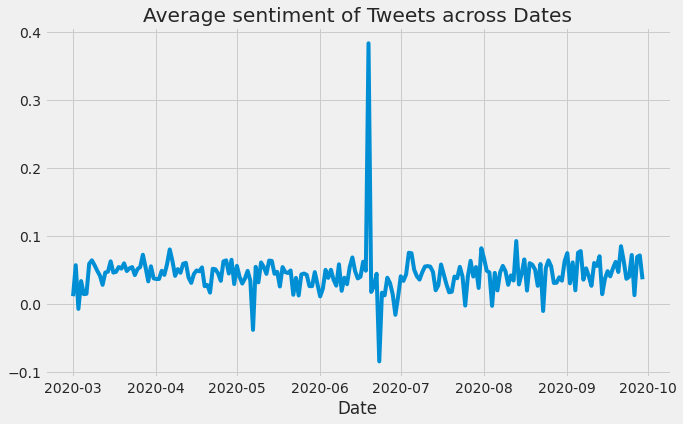

In [ ]:
# plot sentiment fluctuation with date
fig, ax1 = plt.subplots(figsize=(10,6))
df.groupby(['Date']).mean()['polarity'].plot(kind = 'line')
plt.title('Average sentiment of Tweets across Dates')

In [ ]:
def create_wordcloud(text):
    mask = np.array(Image.open("/content/gdrive/My Drive/Capstone-project/images/cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                   mask = mask,
                   max_words = 3000,
                   stopwords = stopwords,
                   repeat = True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    print("Word cloud saved successfully")
    path = "wc.png"
    display(Image.open(path))

Word cloud saved successfully


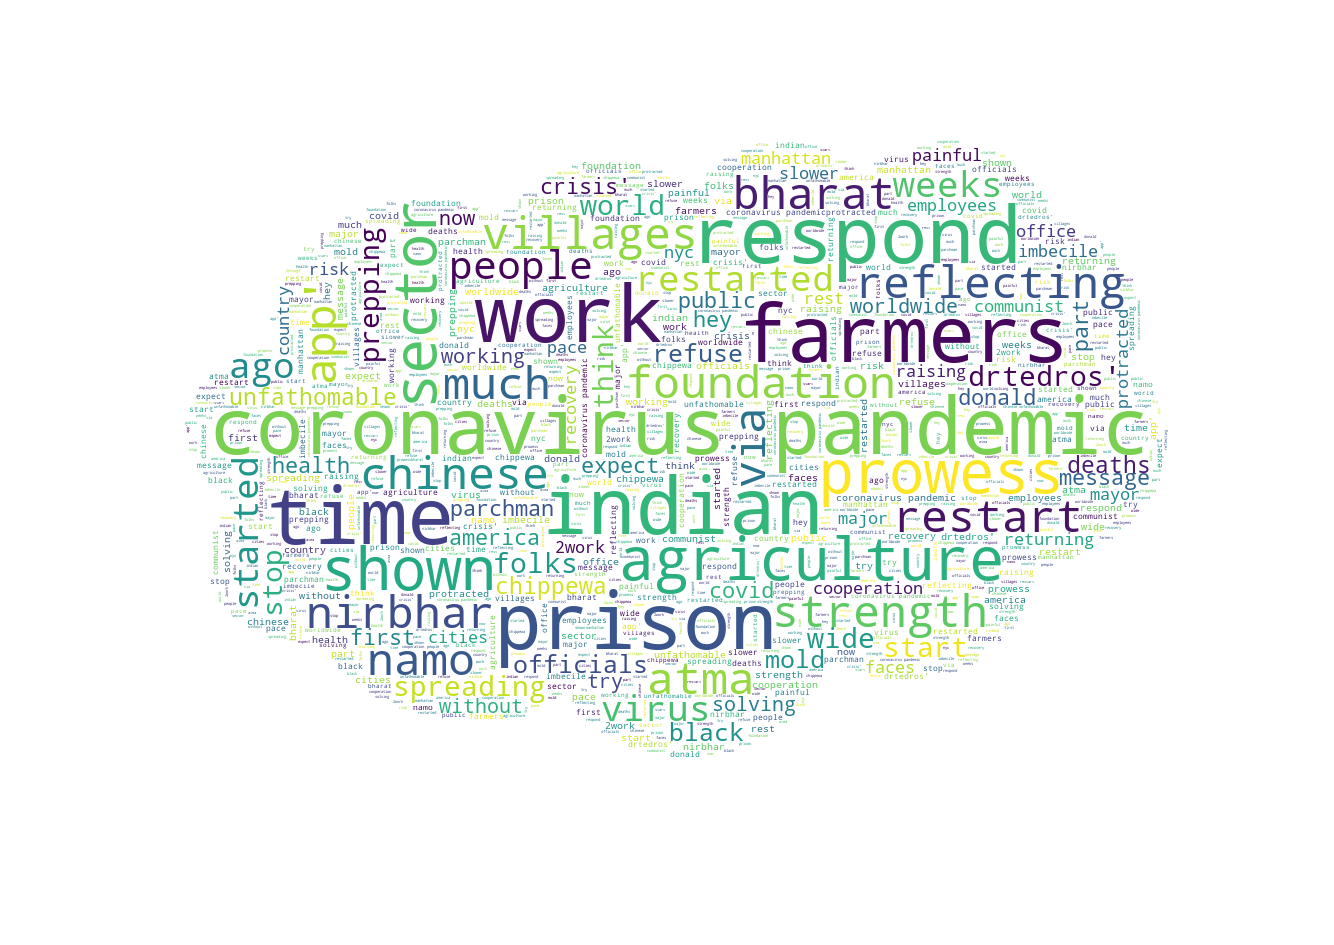

In [ ]:
create_wordcloud(df["text_nlp"].values)

### Modeling with Classification

In [ ]:
"""CountVectorizer provides a simple way to both tokenize a collection of 
text documents and build a vocabulary of known words, 
but also to encode new documents using that vocabulary.

reminder: cv = CountVectorizer(stop_words = 'english')
          words = cv.fit_transform(df['text_nlp'])
 """
print(words[0])

  (0, 60002)	1
  (0, 77531)	2
  (0, 3837)	1
  (0, 15816)	1
  (0, 53785)	1
  (0, 60003)	1
  (0, 76477)	1
  (0, 5658)	1
  (0, 75428)	1
  (0, 67184)	1
  (0, 66778)	1
  (0, 77585)	1
  (0, 76968)	1
  (0, 23787)	1


In [ ]:
cv.get_feature_names()[77531]

'work'

In [ ]:
#number of non-zero values
words.nnz

2130832

Transform a count matrix to a normalized tf or tf-idf representation.
term-frequency, term-frequency times inverse document-frequency

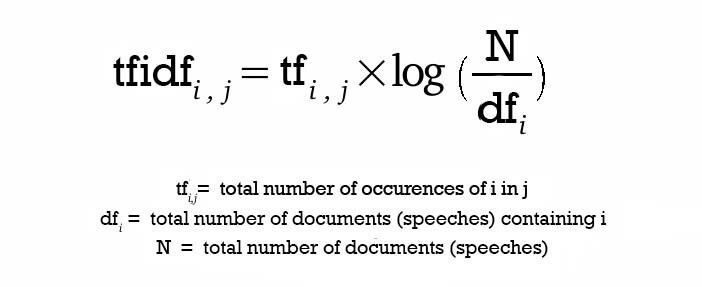

In [ ]:
from IPython.display import Image
Image('/content/gdrive/My Drive/Capstone-project/images/tfidf.jpeg')

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
# tfidf weighting
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(words)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [ ]:
print(tfidf_transformer.transform(words[0]))

  (0, 77585)	0.1445561288237182
  (0, 77531)	0.367687334780829
  (0, 76968)	0.28524696709979847
  (0, 76477)	0.2057180445110174
  (0, 75428)	0.18902916273305775
  (0, 67184)	0.22506896869162862
  (0, 66778)	0.25240520466991345
  (0, 60003)	0.39496085191566266
  (0, 60002)	0.30754034180982487
  (0, 53785)	0.13277775595685837
  (0, 23787)	0.33321711766770856
  (0, 15816)	0.22569247951343488
  (0, 5658)	0.24493710576597774
  (0, 3837)	0.28276731343662276


In [ ]:
tfidf_text = tfidf_transformer.transform(words)

In [ ]:
len(df['word_count'])

136394

In [ ]:
# Transforming the two columns into sparse matrices
from scipy.sparse import coo_matrix, hstack


txt_length = coo_matrix(df['text_len']).reshape(136394,1)
wrd_cnt = coo_matrix(df['word_count']).reshape(136394,1)

features = hstack([tfidf_text, txt_length, wrd_cnt])

# Preview difference in shapes
print("Shape of text column sparse matrix: ", tfidf_text.shape)
print("Shape of concatenated features sparse matrix: ", features.shape)

Shape of text column sparse matrix:  (136394, 79419)
Shape of concatenated features sparse matrix:  (136394, 79421)


In [ ]:
# Creating the target variable based on the sentiment column
##
mapper = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

df['target'] = df['sentiment'].map(mapper)
df.sample(5)

,tweet,Date,month,time,text_nlp,text_len,word_count,polarity,sentiment,target
108791,#JantaCurfew\nIndians are set to observe Janta...,2020-03-22,Mar,07:04:08,indians set observe janta curfew staying indoo...,149,26,0.000000,neutral,0
34924,"So during a coronavirus pandemic, in which mor...",2020-06-02,Jun,19:17:15,"coronavirus pandemic, 105, americans died 40 m...",206,33,0.000000,neutral,0
82167,Breaking News: Sierra Leone’s President Julius...,2020-04-05,Apr,13:51:21,breaking news: sierra leone’s president julius...,244,37,0.133333,positive,1
16678,The #Coronavirus pandemic has had a wide effec...,2020-07-21,Jul,11:43:37,pandemic wide effect property . things start r...,157,28,-0.100000,negative,-1
27643,Harris County lied about no tolls during Coron...,2020-06-22,Jun,18:37:48,harris county lied tolls coronavirus pandemic ...,84,11,0.000000,neutral,0


In [ ]:
from sklearn.model_selection import train_test_split
X=features
y=df['target']

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 33)

### Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter = 10000, solver='lbfgs', penalty='l2', C=0.1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred = lr.predict(X_train)
#metrics.accuracy_score(y_true = y_train, y_pred = pred)
print("Training score: ",metrics.accuracy_score(y_true = y_train, y_pred = pred))

Training score:  0.765798890384426


In [ ]:
pred = lr.predict(X_test)
#metrics.accuracy_score(y_true = y_test, y_pred = pred)
print("Testing accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = pred))

Testing accuracy:  0.7393970362800204


In [ ]:
lr_pred = lr.predict(X_test)

### Linear SVC

In [ ]:
svc = LinearSVC(C=0.1, class_weight=None, dual=False, max_iter=1000)

In [ ]:
svc.fit(X_train, y_train)

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
pred = svc.predict(X_train)
#metrics.accuracy_score(y_true = y_train, y_pred = pred)
print("Training accuracy: ", metrics.accuracy_score(y_true = y_train, y_pred = pred))

Training accuracy:  0.872317608307891


In [ ]:
pred = svc.predict(X_test)
#metrics.accuracy_score(y_true = y_test, y_pred = pred)
print("Testing accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = pred))

Testing accuracy:  0.823043256092955


In [ ]:
svc_pred = svc.predict(X_test)

### XGBoost

In [ ]:
xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
pred = xgb.predict(X_train)
#metrics.accuracy_score(y_true = y_train, y_pred = pred)
print("Training accuracy: ",metrics.accuracy_score(y_true = y_train, y_pred = pred))

Training accuracy:  0.6428876268014838


In [ ]:
pred = xgb.predict(X_test)
#metrics.accuracy_score(y_true = y_test, y_pred = pred)
print("Testing accuracy: ",metrics.accuracy_score(y_true = y_test, y_pred = pred))

Testing accuracy:  0.6334451578503033


In [ ]:
xgb_pred = xgb.predict(X_test)

In [ ]:
print("Logistic Regression \n----------------------------------")
#print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
print("Linear SVC \n---------------------------------")
#print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))
print("Xgboost Classifier \n----------------------------------")
#print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

Logistic Regression 
----------------------------------
              precision    recall  f1-score   support

          -1       0.85      0.53      0.65     12168
           0       0.71      0.74      0.72     13297
           1       0.72      0.87      0.79     19546

    accuracy                           0.74     45011
   macro avg       0.76      0.71      0.72     45011
weighted avg       0.75      0.74      0.73     45011

Linear SVC 
---------------------------------
              precision    recall  f1-score   support

          -1       0.85      0.68      0.76     12168
           0       0.77      0.87      0.82     13297
           1       0.85      0.88      0.86     19546

    accuracy                           0.82     45011
   macro avg       0.82      0.81      0.81     45011
weighted avg       0.83      0.82      0.82     45011

Xgboost Classifier 
----------------------------------
              precision    recall  f1-score   support

          -1       0.86   

In [ ]:
print("Recall Score:\n")
print("logistic regression: ",metrics.recall_score(y_test, lr_pred,average='macro'))
print("linear SVC: ",metrics.recall_score(y_test, svc_pred,average='macro'))
print("XGBooost Classifier: ",metrics.recall_score(y_test, xgb_pred,average='macro'))
print(40*"-")


Recall Score:

logistic regression:  0.7121659044813541
linear SVC:  0.810947472088059
XGBooost Classifier:  0.5936258984481888
----------------------------------------


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

**We'll use scikit-learn's TfidfVectorizer to tokenize the documents and create as document-feature matrix. This fuction also performs the necessary transformation to convert the term weights into TFxIDF weights. **

In [ ]:
data = df['text_nlp']

tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 2000)

tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [ ]:
vector = pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()
vector.head()

,00,10,100,11,12,13,14,15,150,16,17,18,19,1st,20,200,2008,2016,2019,2020,2021,21,22,23,24,25,250,26,27,28,29,2nd,30,300,31,33,35,40,400,45,...,woman,women,won,wonder,wondering,word,words,work,worked,worker,workers,workforce,working,works,world,worldwide,worried,worry,worse,worst,worth,wow,write,writing,written,wrong,wuhan,ya,yatra,year,years,yemenis,yes,yesterday,york,young,youth,youtube,zero,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460188,0.0,0.0,0.0,0.0,0.000000,0.0,0.180923,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.329908,0.0,0.000000,0.379449,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.243769,0.0,0.000000,0.000000,0.0,0.333665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
class Kmeans:
    ''' K Means Clustering
    
    Parameters
    -------------------
        k: int, # of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithms, default: 200
        
    Attributes
    ------------------
        centroids: array, k, number_features
        
        cluster_labels: label for each data point
        
    '''
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
    def intialize_centroids(self,data):
        
        '''Randomly Initialize Centroids
        
        Parameters
        --------------
        data: array or matrix, number_rows, number_features
        
        Returns
        -------------
        centroids: array of k centroids chosen as random data points
        '''
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        
        return self.centroids
    
    def assign_clusters(self,data):
        '''Compute distance of data from clusters and assign data point 
        to closest cluster.
        
        Parameters 
        ------------
        data: array or matrix, number_rows, number_features
        
        Returns 
        ------------
        cluster_labels: index which minimizes the distance of data to each cluster
        
        '''
        
        if data.ndim == 1:
            data = data.reshape(-1,1)
            
        dist_to_centroid = pairwise_distances(data,self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return self.cluster_labels
    
    def update_centroids(self,data):
        '''Computes average of all data points in cluster and assigns 
           new centroids as average of data points
           
           Parameters
           -------------
           data: array or matirx, number_rows, number_features
           
           Returns
           -------------
           centroids: array, k, number_features
           '''
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    
    def predict(self,data):
        '''Predict which cluster data point belongs to
        
        Parameters
        --------------
        data: array or matirx, number_rows, number_features
        
        Returns
        -------------
        cluster_labels: index which minimizes the distance of data to each
        cluster
        '''
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        '''
        This function contains the main loop to fit the algorithm
        Implements initialize centroids and update_centroids according 
        to max_iter
        ---------------------
        
        Returns
        ------------
        instance of kmeans class
        
        '''
        self.centroids = self.intialize_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):
            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)
            if iter % 100 == 0:
                print('Running Model Iteration %d ' %iter)
        print('Model finished running')
        return self

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


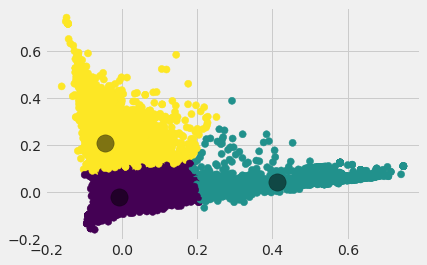

In [ ]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5)

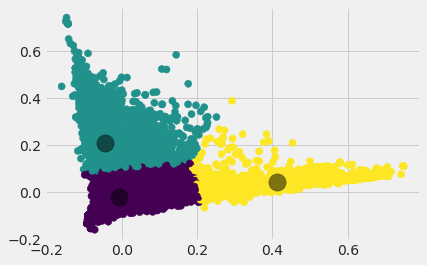

In [ ]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto') 
fitted = kmeans.fit(Y_sklearn)
kmeans_prediction = kmeans.predict(Y_sklearn)

skcenters = fitted.cluster_centers_

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=kmeans_prediction, s=50, cmap='viridis')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

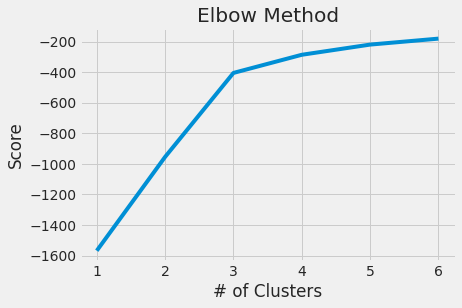

In [ ]:
num_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in num_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(num_clusters, score)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

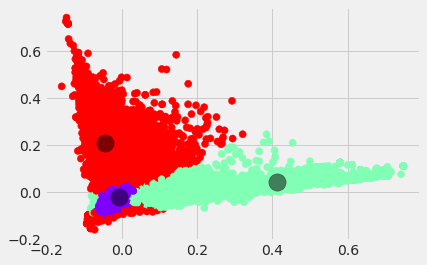

In [ ]:
# Gaussian Mixture Model 

from sklearn.mixture import GaussianMixture as gm


gauss = gm(n_components=3) 
fit = gauss.fit(Y_sklearn)
gauss_prediction = gauss.predict(Y_sklearn)

#skcenters = fitted.cluster_centers_

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=gauss_prediction, s=50, cmap='rainbow')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

In [ ]:
# function that identifies the features with the highest mean tf_idf 
# scores across each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, kmeans_prediction, 15)

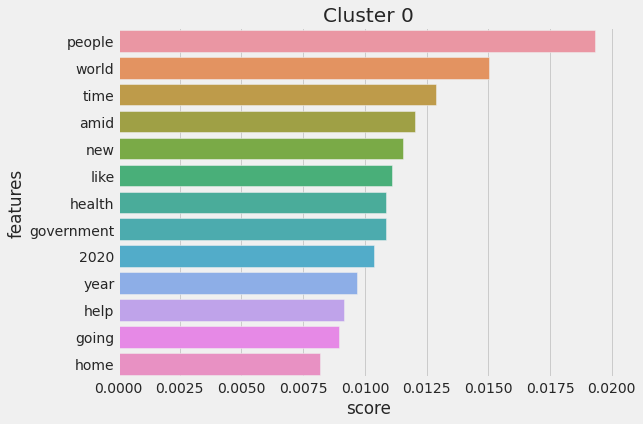

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=dfs[0][2:17]);
plt.title('Cluster 0')
plt.show()

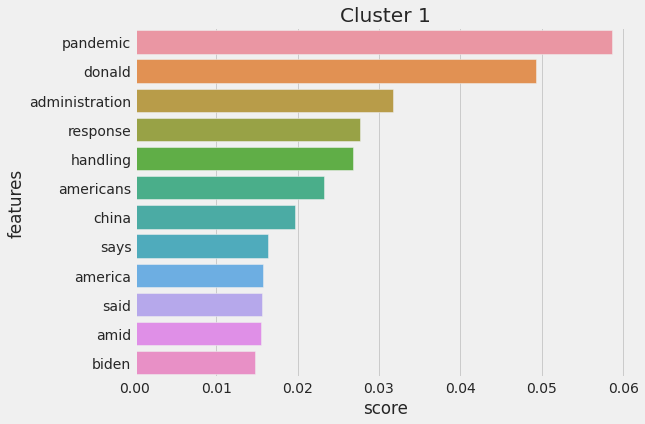

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=dfs[1][3:20]);
plt.title('Cluster 1')
plt.show()

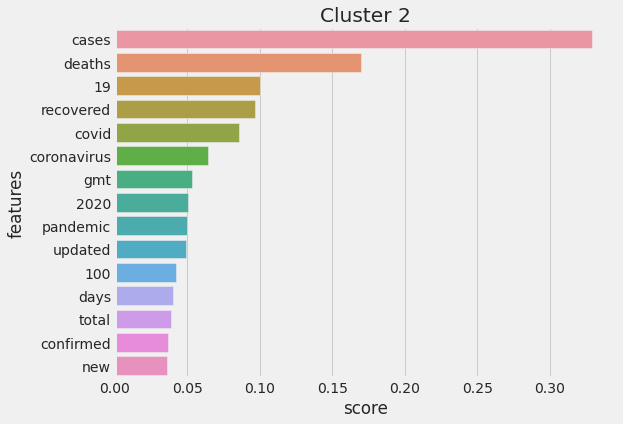

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=dfs[2][:15]);
plt.title('Cluster 2')
plt.show()

In [ ]:
for i, feats in enumerate(dfs):
    feats.to_csv('/content/gdrive/My Drive/Capstone-project/df_'+str(i)+'.csv')

In [ ]:
warnings.filterwarnings('ignore')

def plot_features(dfs):
    fig = plt.figure(figsize=(16,10))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();


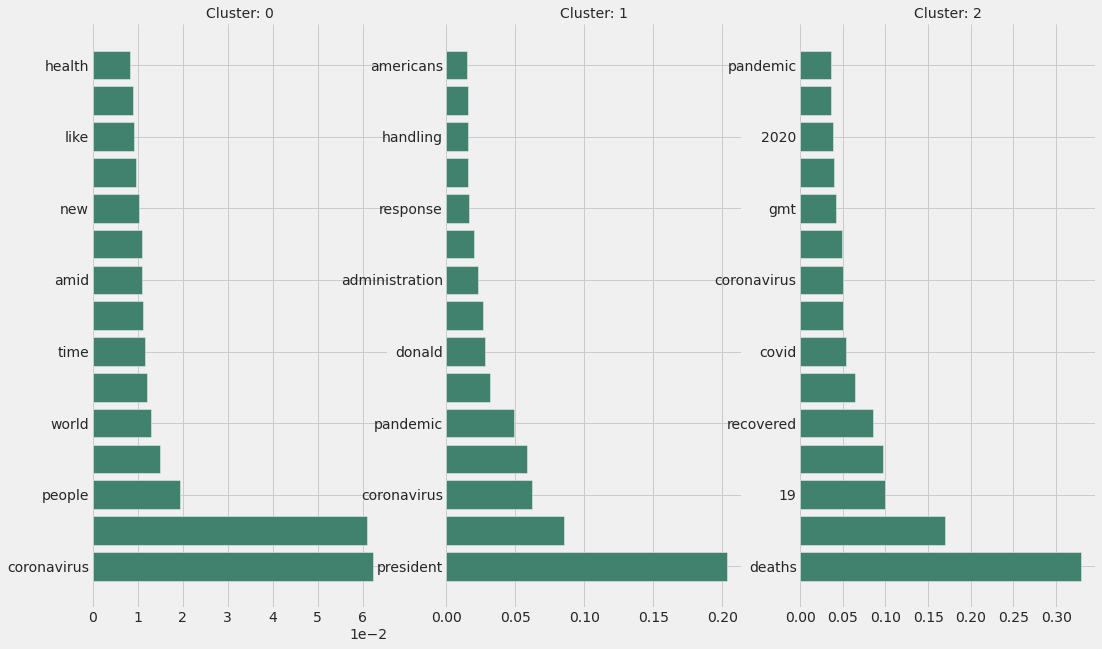

In [ ]:
plot_features(dfs)

### Topic Modeling

In [ ]:
%pylab inline

import pickle as pk
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


In [ ]:
docs = array(df['text_nlp'])

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [ ]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [ ]:

docs = docs_preprocessor(docs)

In [ ]:
docs[:1]

[['restart',
  'work',
  'chinese',
  'people',
  'restarted',
  'work',
  'week',
  'virus',
  'started',
  'spreading',
  'world',
  'wide',
  'drtedros']]

### Compute bigrams/trigrams:
Since topics are very similar what would make distinguish them are phrases rather than single/individual words.

In [ ]:
from gensim.models import Phrases

In [ ]:
bigram = Phrases(docs, min_count=20)## Add bigrams and trigrams to docs (only ones that appear 20 times or more).
trigram = Phrases(bigram[docs])

In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Remove rare and common tokens:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initial documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initial documents: 93206
Number of unique words after removing rare and common words: 22354


In [ ]:
#Vectorize data:
#The first step is to get a bag-of-words representation of each doc.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 22354
Number of documents: 136394


### Train LDA model

In [ ]:
from gensim.models import LdaModel

In [ ]:
# Set training parameters.
warnings.filterwarnings("ignore", category=DeprecationWarning) 

num_topics = 3
chunksize = 500 # size of the doc looked at every pass
passes = 10 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

CPU times: user 10min 43s, sys: 617 ms, total: 10min 43s
Wall time: 10min 45s


In [ ]:
#pip install pyLDAvis

In [ ]:
#supress all warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [ ]:
model.show_topics()

[(0,
  '0.014*"case_death" + 0.009*"people" + 0.008*"year" + 0.007*"time" + 0.006*"wear_mask" + 0.006*"amid" + 0.006*"death" + 0.006*"government" + 0.005*"world" + 0.005*"case"'),
 (1,
  '0.041*"united_state" + 0.022*"president_donald" + 0.021*"public_health" + 0.019*"death_toll" + 0.017*"around_world" + 0.014*"next_year" + 0.012*"small_business" + 0.011*"climate_change" + 0.010*"prime_minister" + 0.008*"across_country"'),
 (2,
  '0.046*"president_trump" + 0.036*"first_time" + 0.034*"donald_trump" + 0.025*"supreme_court" + 0.024*"trump" + 0.022*"trump_administration" + 0.019*"white_house" + 0.013*"health_care" + 0.012*"boris_johnson" + 0.011*"wearing_mask"')]

In [ ]:
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.055555 -0.320589       1        1  59.214979
1     -0.287038  0.202725       2        1  22.515659
2      0.342593  0.117864       3        1  18.269362, topic_info=                           Term          Freq  ...  logprob  loglift
1230            president_trump  34597.000000  ...  30.0000  30.0000
1762               united_state  38523.000000  ...  29.0000  29.0000
3010                 first_time  27538.000000  ...  28.0000  28.0000
299                donald_trump  25633.000000  ...  27.0000  27.0000
5160              supreme_court  19178.000000  ...  26.0000  26.0000
...                         ...           ...  ...      ...      ...
564   donald_trump_donald_trump   3538.524002  ...  -5.3649   1.6999
5364           hundred_thousand   3480.756418  ...  -5.3814   1.6999
87                        trump  18080.041518  ...  -3.7338   1.2184
588                   president   6981.335229  ...  -4.6854   1.1840
189                    american   4881.886527  ...  -5.0431   0.6704

[148 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4181      2  1.000022  across_country
3280      2  0.999951    across_globe
189       1  0.608553        american
189       2  0.034239        american
189       3  0.357172        american
...     ...       ...             ...
2113      1  0.999960    world_health
322       1  0.883626            year
322       2  0.084631            year
322       3  0.031719            year
1026      1  0.999940    young_people

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

From creators of this visualization-ref http://vis.stanford.edu/files/2012-Termite-AVI.pdf <br>
**The left panel**circles represent different topics and the distance between them. Similar topics appear closer and the dissimilar topics farther. The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus. An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.

**The right panel**, include the bar chart of the top 30 terms. When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics. Selecting each topic on the right, modifies the bar chart to show the "relevant" terms for the selected topic. Relevence is defined as in footer 2 and can be tuned by parameter  λ , smaller  λ  gives higher weight to the term's distinctiveness while larger  λ s corresponds to probablity of the term occurance per topics.

In [ ]:
n_words = 20

topic_words = pd.DataFrame({})

for i, topic in enumerate(model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.014422,case_death,0
1,0.009030,people,0
2,0.007533,year,0
3,0.007181,time,0
4,0.005822,wear_mask,0


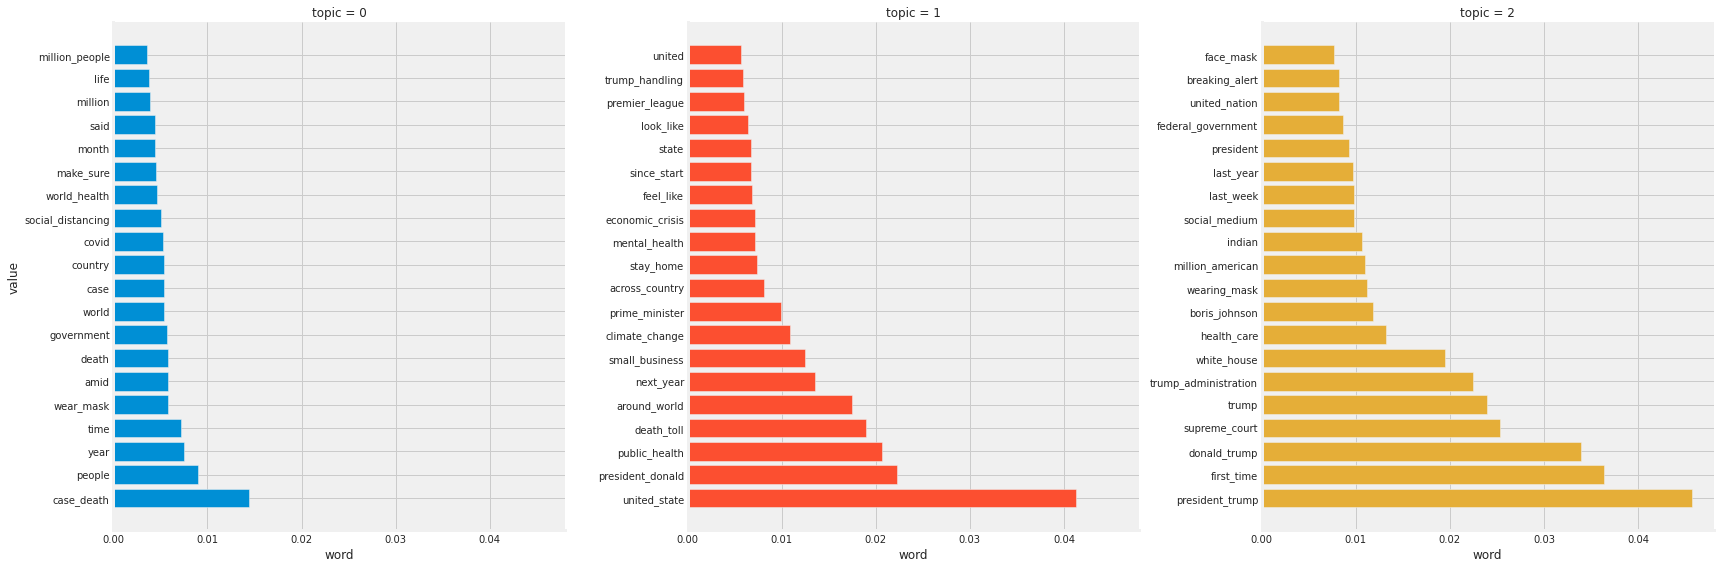

In [ ]:
g = sns.FacetGrid(topic_words, col="topic", hue='topic',col_wrap=3, sharey=False, height=8)
g.map(plt.barh, "word", "value")

In [ ]:
#pyLDAvis.save_html(vis,'/content/gdrive/My Drive/Capstone-project/vis.html')

Compared to k-means, LDA in this work was performed to get multi terms with genism library. Several attempts were applied to find right amount of topics, and the best parameters include 3 number of topics, size of document looked at every pass is 500, 10 passes through documents and 400 iterations with phrases that occur 20 times or more, completed in 10 minutes. We are able to define our topics based on the findings, and pyLDAvis is useful to visualize these terms (Fig. 7). The blue bars below show the overall term frequency. Selecting each topic on the right, modifies the bar chart to show the relevant terms for the selected topic. The left panel circles represent different topics and the distance between them. Similar topics appear closer and dissimilar topics farther, since we applied multi terms to our model, we could define that the first topic=0 is about alerts on pandemic, topic1 is about negative feelings and topic=2 is about updates and politics when relevance of lambda is high.